In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
import xarray
import pickle
import cartopy.feature as cfeature
import math
import cartopy.crs as ccrs
import scipy
import cartopy
import datetime
from scipy.stats import binned_statistic
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
import kuka_tools as kt

In [2]:
dir = '/home/robbie/Dropbox/kuka_bare/data/rothera/netcdfs/20230830'

In [3]:
listfiles = os.listdir(dir)
listfiles

# ku_files = sorted([f for f in listfiles if 'Ku-Scat' in f])[-2:]
ka_files = sorted([f for f in listfiles if 'Ka-Scat' in f])[-2:]

# ku_files

(-1.0, 35.0)

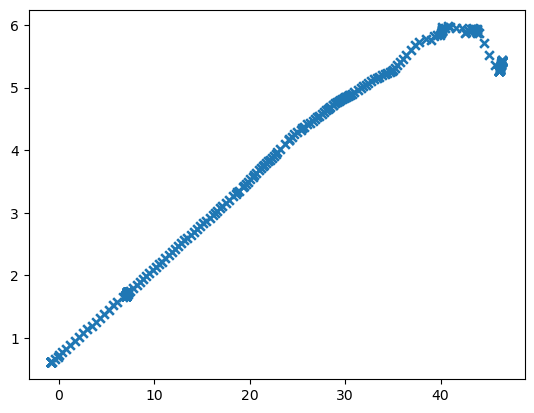

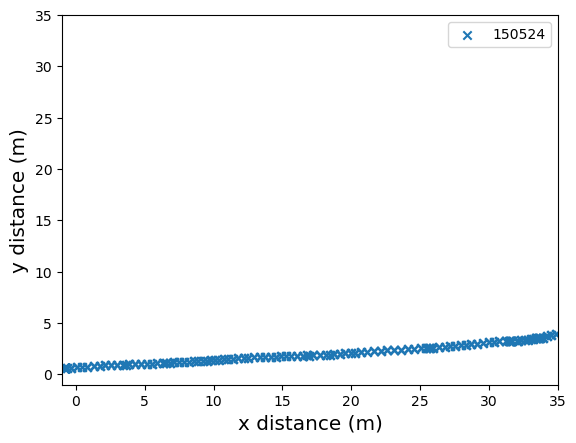

In [4]:
x,y=kt.plot_pos(ka_files[0],dir,plot=False)

x0 = -2300414.994491106; y0 = 923485.871699531
xy_dict = {}

for f in ka_files:

    x,y = kt.plot_pos(f,dir,x0=x0,y0=y0)

    xy_dict[f] = (x,y)

# plt.scatter(x0,y0)
plt.legend()
plt.xlabel('x distance (m)',fontsize='x-large')
plt.ylabel('y distance (m)',fontsize='x-large')

plt.xlim(-1,35)
plt.ylim(-1,35)

1094
0


(250.0, 300.0)

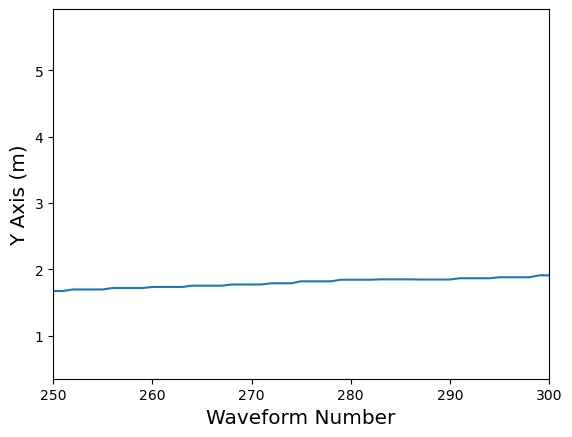

In [5]:
for f in ka_files[0:2]:
    x,y = xy_dict[f]
    print(np.argmin(x))
    times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in Dataset(f'{dir}/{f}')['start_time']])
plt.plot(y)
plt.ylabel('Y Axis (m)',fontsize='x-large')
plt.xlabel('Waveform Number',fontsize='x-large')

plt.xlim(250,300)

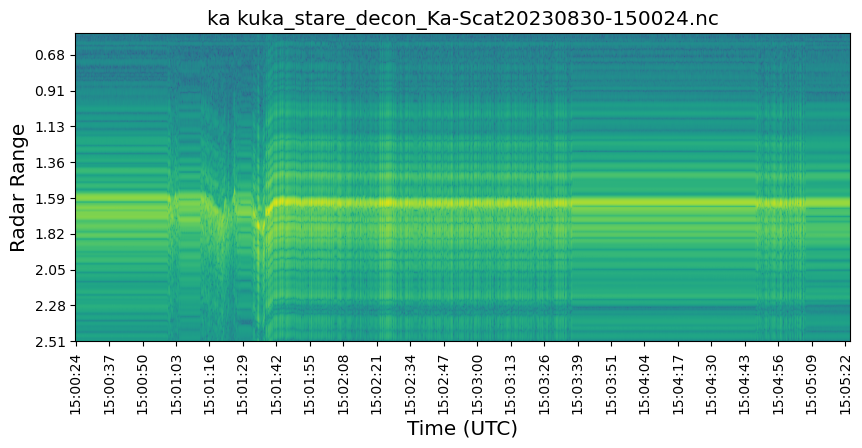

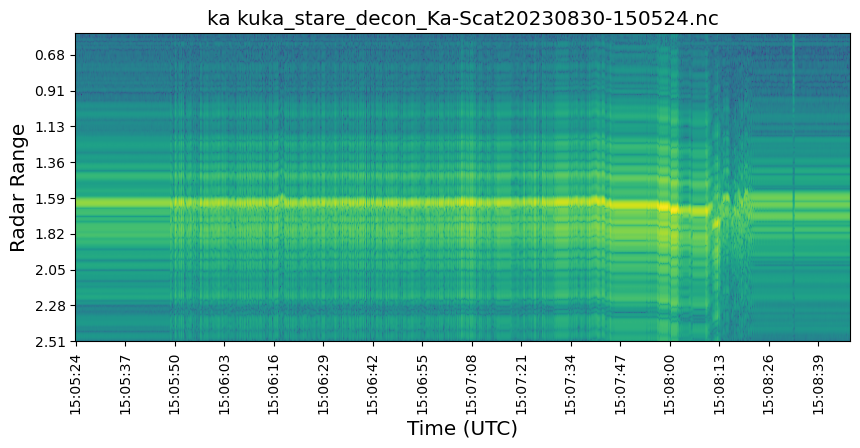

In [12]:
for f in ka_files[0:2]:
    kt.plot_file(f,'ka',dir,)
    plt.xlabel('Time (UTC)',fontsize='x-large')
    plt.ylabel('Radar Range',fontsize='x-large')

In [21]:
foi = ka_files[0]
d = Dataset(f'{dir}/{foi}')
x,y = xy_dict[foi]

range = np.array(d['range'])

times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']])

mintime=0
maxtime=-1

x_ = 0; y_ = 0

along_track = np.sqrt((x-x_)**2 + (y-y_)**2)

xdiff = np.diff(x)
ydiff = np.diff(y)
speed = np.sqrt(np.square(xdiff)+np.square(ydiff))
speed=list(speed)+[0]
# df = df[df['speed']>0.1]


nrcs = pd.DataFrame(kt.get_nrcs(d,'ka'))
# nrcs['corr']=kt.calc_corrs(d,1,4)


# nrcs= nrcs[nrcs['corr']<0.999]
# nrcs.reset_index(inplace=True,drop=True)

nrcs['along_track']=along_track
nrcs['speed']=speed

nrcs_return = nrcs.iloc[mintime:maxtime]

nrcs_return = nrcs_return.sort_values('along_track').reset_index(drop=True)

nrcs_return = nrcs_return[nrcs_return['along_track']<30]


nrcs_return

,vv,hv,vh,hh,corr,along_track,speed
0,3.529518,0.004402,0.031626,3.643751,0.987159,0.712232,0.000000
1,0.727689,0.012909,0.018957,0.881424,0.812263,0.712232,0.266807
2,5.750999,0.030949,0.013479,6.159456,0.977637,0.712232,0.000000
3,1.799892,0.017635,0.011954,1.630134,0.998847,0.712232,0.000000
4,0.119049,0.012439,0.013039,0.152111,0.366382,0.728343,0.000000
...,...,...,...,...,...,...,...
741,0.251182,0.009511,0.013396,0.236618,0.976231,29.703532,0.196984
742,0.530459,0.003288,0.006161,0.990312,0.757100,29.703532,0.000000
743,0.399947,0.020731,0.008288,0.366970,0.955813,29.870513,0.167091
744,0.662873,0.007174,0.008944,0.414841,0.938752,29.870513,0.000000


In [22]:
power_threshold = np.max(nrcs_return['vv'][nrcs_return['along_track']<25])
power_threshold_arg = np.argmax(nrcs_return['vv'][nrcs_return['along_track']<25])
power_threshold,power_threshold_arg

(8.25434394676057, 611)

In [23]:
start_ind = np.argmax(nrcs_return['vv']>power_threshold)
start_along_track = nrcs_return['along_track'].iloc[start_ind]

nrcs_reverse = nrcs_return.reindex(index=nrcs_return.index[::-1])
end_ind = np.argmax(nrcs_reverse['vv']>power_threshold)
end_along_track = nrcs_reverse['along_track'].iloc[end_ind]
start_along_track,end_along_track

(26.360457731719688, 27.920577169916292)

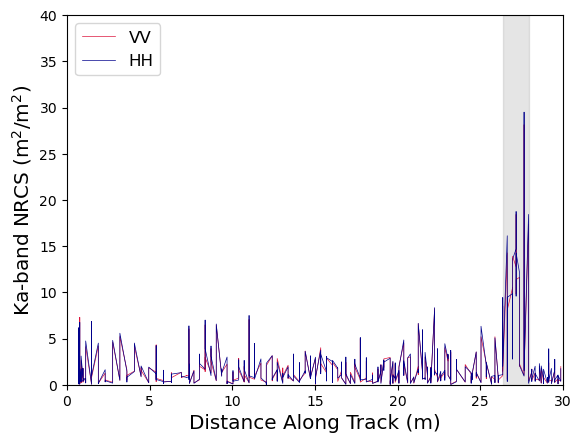

In [28]:
plt.plot(nrcs_return['along_track'],
         nrcs_return['vv'],
         label='VV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['hh'],
         label='HH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ka-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')



plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
plt.ylim(0,40)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

In [30]:
ff_pickles = '/home/robbie/Dropbox/kuka_bare/data/pickles/FF_fig'
pickle.dump((nrcs_return,
             start_along_track,
             end_along_track),
            open(f'{ff_pickles}/ka30.p','wb'))

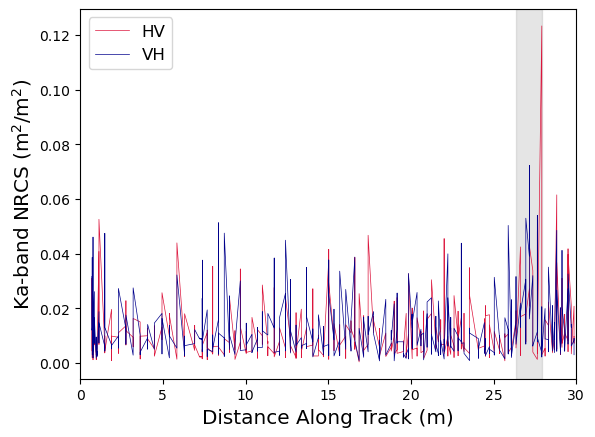

In [25]:
plt.plot(nrcs_return['along_track'],
         nrcs_return['hv'],
         label='HV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['vh'],
         label='VH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ka-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')



plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
# plt.ylim(0,40)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

In [26]:
pickle.dump(nrcs_return,open('../../data/pickles/NRCS_830_KA.p','wb'))
start_along_track,end_along_track

(26.360457731719688, 27.920577169916292)

In [ ]:
bin_centres = np.arange(0.25,26.01,0.5)

plt.plot(bin_centres,bs[0])

thresh=25

mean = np.nanmean(bs[0][bin_centres<thresh])

plt.plot([0,thresh],[mean,mean],color='k',ls='--')

print(mean)

plt.show()

In [ ]:
plt.hist(speed)

In [ ]:
# def weighted_violin(nrcs,speed):

speed_1000 = np.array(speed)*10000

weighted_list = []
for i,s in zip(vv_valid,speed_1000):
    # print(i,s)
    weighted_list+= [i]*int(s)
    
    
weighted_list
plt.violinplot(weighted_list,widths=1,showextrema=False)
plt.axhline(np.nanmean(weighted_list))
plt.axhline(np.nanmedian(weighted_list))

2.226786035207986

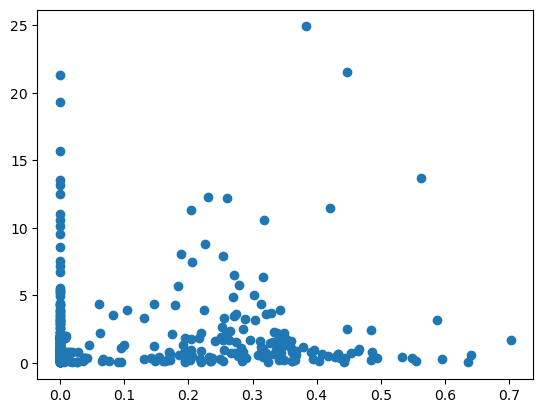

In [12]:
plt.scatter(speed[mintime:maxtime],nrcs['vv'][mintime:maxtime])

vv = nrcs['vv'][mintime:maxtime]

speed_ = np.array(speed[mintime:maxtime])

vv_valid = vv[speed_>0.001]
speed_valid = speed_[speed_>0.001]

np.average(vv_valid,weights=speed_valid)

In [13]:
foi = ku_files[1]
d = Dataset(f'{dir}/{foi}')
x,y = xy_dict[foi]

range = np.array(d['range'])

times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']])

mintime = kt.get_time_index(datetime.datetime(2023,8,31,13,26,20),times)
# maxtime = kt.get_time_index(datetime.datetime(2023,8,31,13,29,8),times)
maxtime=570

x_ = 0; y_ = 0

along_track = np.sqrt((x-x_)**2 + (y-y_)**2)

nrcs = kt.get_nrcs(d,'ka')

pickle_file = '../../data/pickles/830_trans.p'
pickle.dump( (along_track,nrcs), open(pickle_file,'wb'))

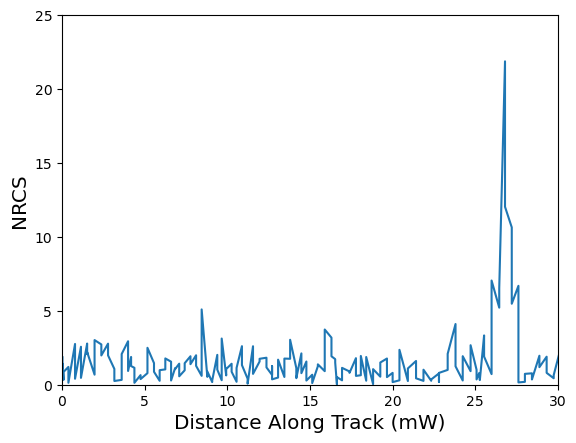

1.2833030931823959


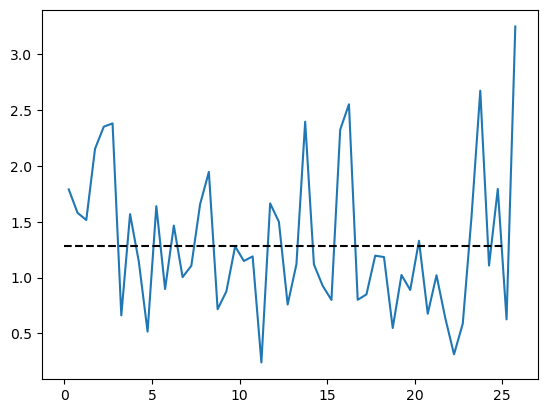

In [14]:
plt.plot(along_track[mintime:maxtime],nrcs['vv'][mintime:maxtime])
bs = binned_statistic(along_track[mintime:maxtime],nrcs['vv'][mintime:maxtime],
                      statistic='mean',bins=np.arange(0,26.1,0.5))

plt.ylabel('NRCS',fontsize='x-large')
plt.xlabel('Distance Along Track (mW)',fontsize='x-large')
plt.ylim(0,25)
plt.xlim(0,30)

plt.show()

bin_centres = np.arange(0.25,26.01,0.5)

plt.plot(bin_centres,bs[0])

thresh=25

mean = np.nanmean(bs[0][bin_centres<thresh])

plt.plot([0,thresh],[mean,mean],color='k',ls='--')

print(mean)

plt.show()